# Questions
- Question 1

    1) There are two soil types

    2) 'Chehalis-350' tells me the soil type and biochar content

    3) Fraction CO2 measures the fraction of CO2 the biochar is responsible for. Grav measures the soil's water content.

- Question 2

    1) Seaborn plots created

    2) Found two plots done

    3) Plots chosen: 'FractionCO2 by Soil and Biochar' (Boxplot) & 'Fractional CO2 vs Biochar by Soil' (Scatterplot). These two plots demonstrate that increasing biochar content decreases its contribution to CO2 respiration. This trend may be observed by noting that the cluster of values for Fractional CO2 shrink into themselves and become more tightly centered around a lower contribution as Biochar content increases.

    4) Found and formatted by printing 'formatted_data' below

- Question 3
    1) Solved
    2) Solved

In [297]:
# Importing stuff
import numpy as np
import pandas as pd
import os 
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [298]:
# Locating file path; note that your data file must be in the same directory as this file
def path_finder(file_name):
    
    directory = os.path.dirname('__file__')
    file_directory = os.path.join(directory, file_name)
    
    # print(f'Found directory: {file_directory}')
    
    return file_directory

In [299]:
# Reading the found file
def file_reader(path):
    
    file_path = path
    
    try:
        csv_read = pd.read_csv(file_path)
        # print('CSV Data loaded successfully')
    
    except Exception as e:
        print('Failed to load data')
        print(f'Error: {e}')
        csv_read = None
        
    return csv_read

In [300]:
# This function creates a dictionary that groups the data by Soil and Biochar
# It works by iterating through all rows in the DataFrame, and creating a key
# based on the row contents.
def data_sorter(data):
    
    grouped_data = {}
    
    for _, row in data.iterrows():
        
        soil_type = row['Soil']
        biochar_content = row['Biochar']
        
        key = (soil_type, biochar_content)
    
        if key not in grouped_data:
            grouped_data[key] = []
            
        grouped_data[key].append(row.to_dict())
        
    return grouped_data

In [301]:
# Finds the relevant statistics data, mean/median/standard dev/... etc
def data_analyzer(data):
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    analysis_results = {}
    
    for key, rows in data.items():
        
        soil_type, biochar_content = key
        key = (soil_type, biochar_content if not pd.isna(biochar_content) else 'Unknown')

        
        df = pd.DataFrame(rows)
        
        stats = {
            'Average FractionCO2': df['FractionCO2'].mean(skipna=True),
            'Median FractionCO2': df['FractionCO2'].median(skipna=True),
            'Std FractionCO2': df['FractionCO2'].std(skipna=True),
            'Average Grav': df['Grav'].mean(skipna=True),
            'Median Grav': df['Grav'].median(skipna=True),
            'Std Grav': df['Grav'].std(skipna=True),
            'Sample Size': len(df)
        }
        
        stats = {k: float(v) if isinstance(v, np.float64) else v for k, v in stats.items()}
        
        analysis_results[key] = stats
        
    return analysis_results

In [302]:
# Formats the analyzed data into a cleaner output that is more legible
def data_formatter(data):
    
    formatted_data = pd.DataFrame.from_dict(data, orient='index')

    formatted_data.reset_index(inplace=True)

    if 'level_0' in formatted_data.columns and 'level_1' in formatted_data.columns:
        formatted_data['Group'] = formatted_data['level_0'].astype(str) + "-" + formatted_data['level_1'].astype(str)
        formatted_data.drop(['level_0', 'level_1'], axis=1, inplace=True)
    else:
        print("Expected 'level_0' and 'level_1' columns not found. Current columns:", formatted_data.columns)
   
    return formatted_data

In [303]:
# Creates scatter plots with variable parameters that may be easily changed
def create_scatter_plot(data, x_col, 
                        y_col, hue_col=None, 
                        style_col=None, title=None):
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=data, x=x_col, 
        y=y_col, hue=hue_col, 
        style=style_col,
        palette='viridis', s=100
        )
    
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title(f'{y_col} vs {x_col}', fontsize=14)
        
    if hue_col or style_col:
        plt.legend(
            title=hue_col if hue_col else style_col, 
            bbox_to_anchor=(1.05, 1), loc='upper left'
            )
        
    plt.tight_layout()
    plt.show()

In [304]:
# This is the same as the scatter plot maker, but it makes box plots instead
def create_box_plot(data, x_col, y_col,
                    hue_col=None, title=None): 
    
    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=data, x=x_col, 
        y=y_col, hue=hue_col,
        palette='viridis',
        )
    
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title(f'{y_col} vs {x_col}', fontsize=14)
        
    if hue_col :
        plt.legend(
            title=hue_col,
            bbox_to_anchor=(1.05, 1), loc='upper left'
            )
        
    plt.tight_layout()
    plt.show()

In [305]:
# Calculates the confidence interval for a given column
def calculate_confidence_interval(data, column, confidence=0.95):
    
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the dataset.")

    mean = data[column].mean()
    std_dev = data[column].std()
    n = len(data[column])

    if n < 2:
        raise ValueError('Not enough data points to calculate a confidence interval.')
    
    t_critical = t.ppf((1 + confidence) / 2, df=n - 1)

    margin_of_error = t_critical * (std_dev / (n ** 0.5))

    lower_bound = float(mean - margin_of_error)
    upper_bound = float(mean + margin_of_error)

    return lower_bound, upper_bound

In [306]:
# Calculates the confidence interval for a single replicate of a specific treatment
def single_replicate_confidence_interval(data, soil, biochar, 
                                         replicate, column, 
                                         confidence=0.95):
    
    filtered_data = data[
        (data['Soil'] == soil) &
        (data['Biochar'] == biochar) &
        (data['Replicate'] == replicate)
    ]

    return calculate_confidence_interval(filtered_data, column, confidence)

In [307]:
# Confidence interval for all replicates
def combined_replicates_confidence_interval(data, soil, 
                                            biochar, column, 
                                            confidence=0.95):

    filtered_data = data[
        (data['Soil'] == soil) &
        (data['Biochar'] == biochar)
    ]

    return calculate_confidence_interval(filtered_data, column, confidence)

In [308]:
# Function to calculate the probability of samples being within the confidence interval
def test_samples_within_confidence_interval(data, column, soil, 
                                            biochar, confidence=0.95,
                                            sample_size=None, 
                                            iterations=None):
 
    filtered_data = data[
                (data['Soil'] == soil) &
                (data['Biochar'] == biochar)
                ]
    
    if column not in filtered_data.columns:
        raise ValueError(f"Column '{column}' not found in the dataset.")

    lower_bound, upper_bound = calculate_confidence_interval(filtered_data, column, confidence)

    within_interval_count = 0

    for _ in range(iterations):
        sample = filtered_data[column].dropna().sample(n=sample_size, replace=True)

        sample_mean = sample.mean()

        if lower_bound <= sample_mean <= upper_bound:
            within_interval_count += 1

    probability = within_interval_count / iterations

    return probability

In [309]:
# - - - - Running the Script - - - - 

csv_data = 'midtermdata.csv' # Define data file name

path = path_finder(csv_data) # Get path

found_data = file_reader(path) # Get data

grouped_data = data_sorter(found_data) # Group data

analyzed_data = data_analyzer(grouped_data) # Analyze data

formatted_data = data_formatter(analyzed_data) # Format data

# Gets the confidence interval for a single replicate

soil_of_interest = input('Soil Type: ')
biochar_amount_of_interest = input('Biochar Content: ')
data_point_of_interest = input('Data point: ')

ci_single = single_replicate_confidence_interval( 
    data=found_data, soil=soil_of_interest, biochar=biochar_amount_of_interest,
    replicate=1, column=data_point_of_interest)

# Gets the confidence interval for all replicates
ci_combined = combined_replicates_confidence_interval(
    data=found_data, soil=soil_of_interest,
    biochar=biochar_amount_of_interest, column=data_point_of_interest)

# Finding the probability that the sample average lies within the confidence interval
probability = test_samples_within_confidence_interval(
    data=found_data, column=data_point_of_interest, soil=soil_of_interest,
    biochar=biochar_amount_of_interest, confidence=0.95,
    sample_size=5, iterations=10000
)

print(f"Probability of a sample of {soil_of_interest}-{biochar_amount_of_interest} being within the confidence interval: {probability:.2f}%")
# - - - Debugging Scraps - - -

print("95% Confidence Interval for All Replicates Combined:",
    f"{np.round(ci_combined, 2)}%"      
    )
print(f'95% Confidence interval for single replicate of {soil_of_interest}{biochar_amount_of_interest}:', 
      f"{np.round(ci_single, 2)}%"
      )


'''print(formatted_data)
# print(formatted_data.columns)
# print(formatted_data)

for key, stats in analyzed_data.items():
    print(f'Group: {key}')
    for stat_name, value in stats.items():
        print(f'{stat_name}: {value}')
    print('-' * 40)

print(analyzed_data)
print(grouped_data)
print(found_data)'''

ValueError: Not enough data points to calculate a confidence interval.

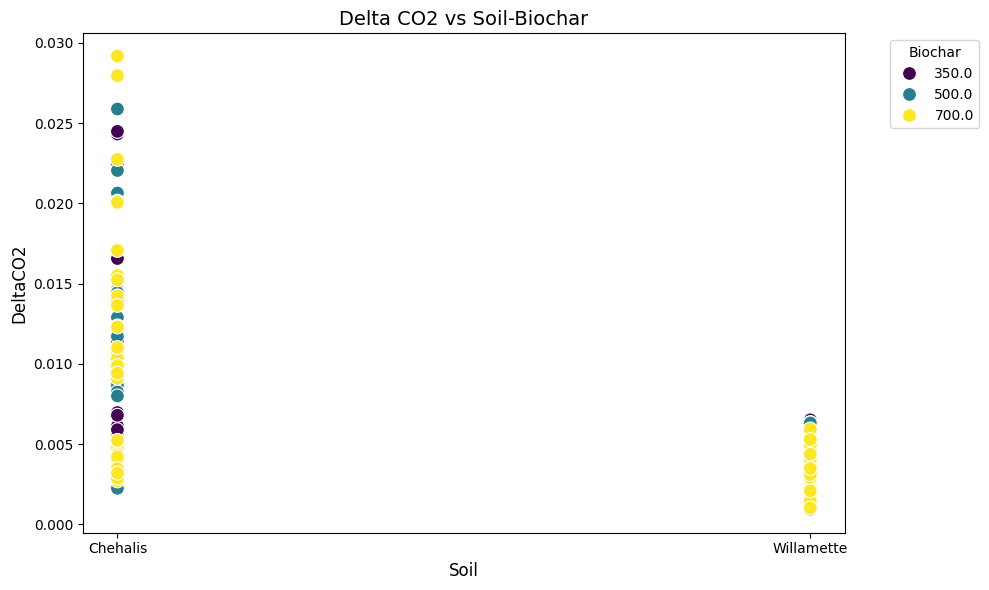

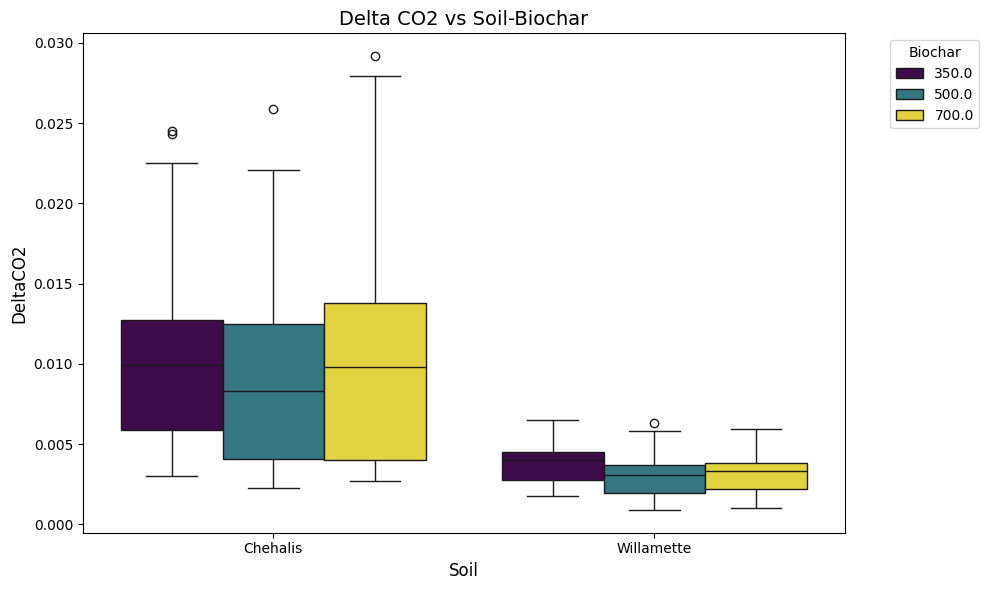

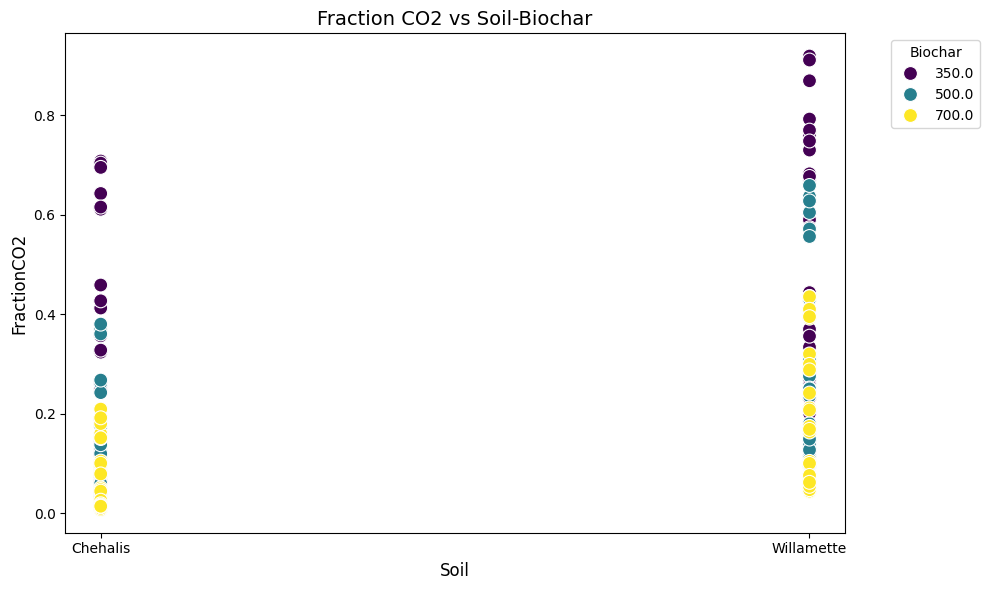

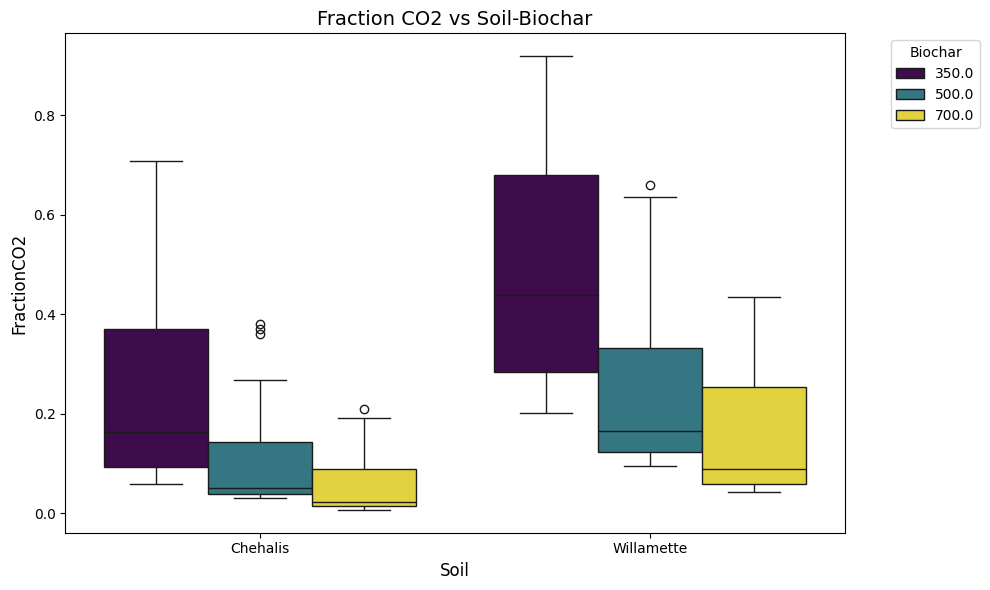

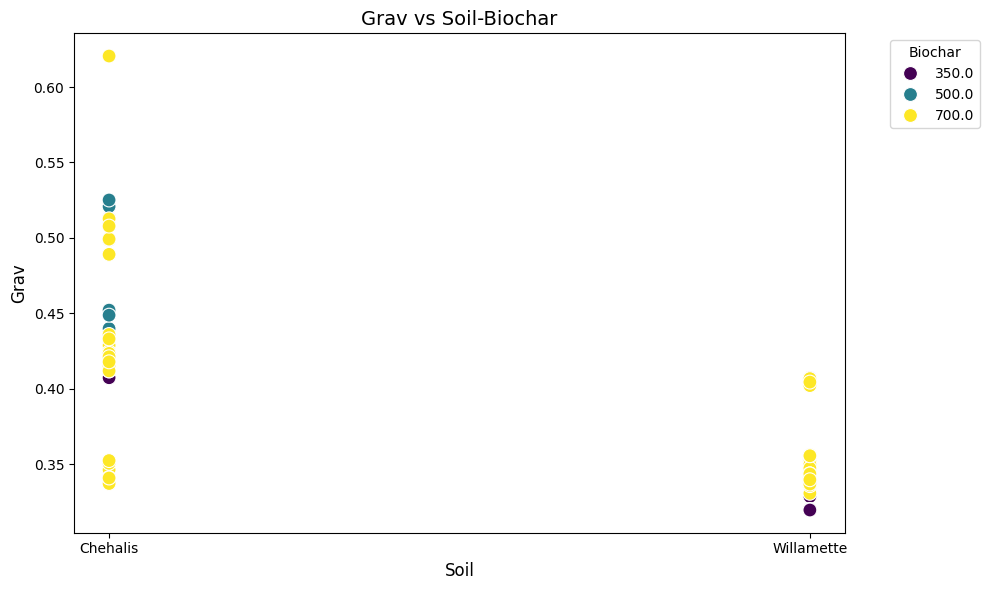

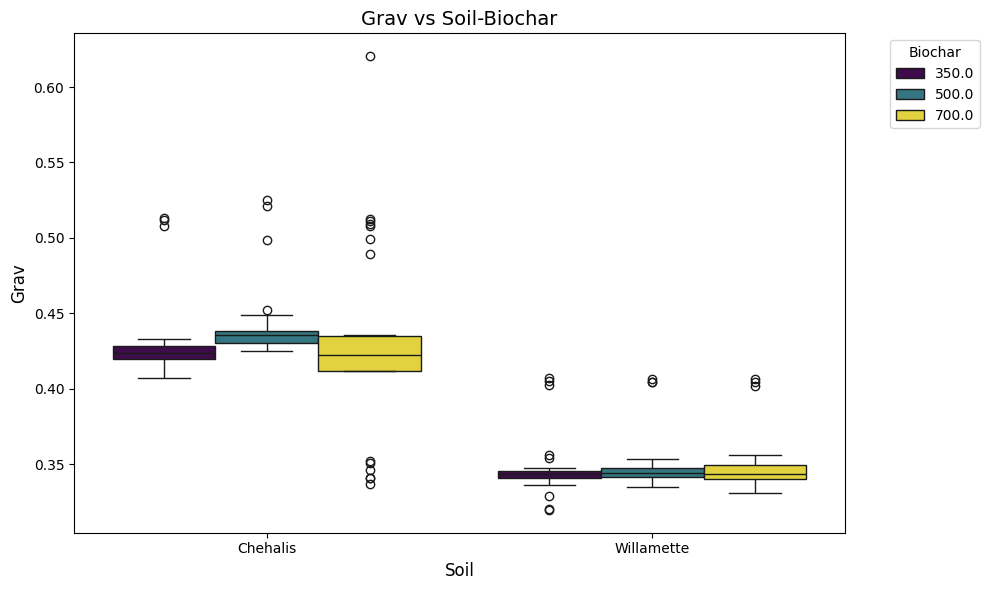

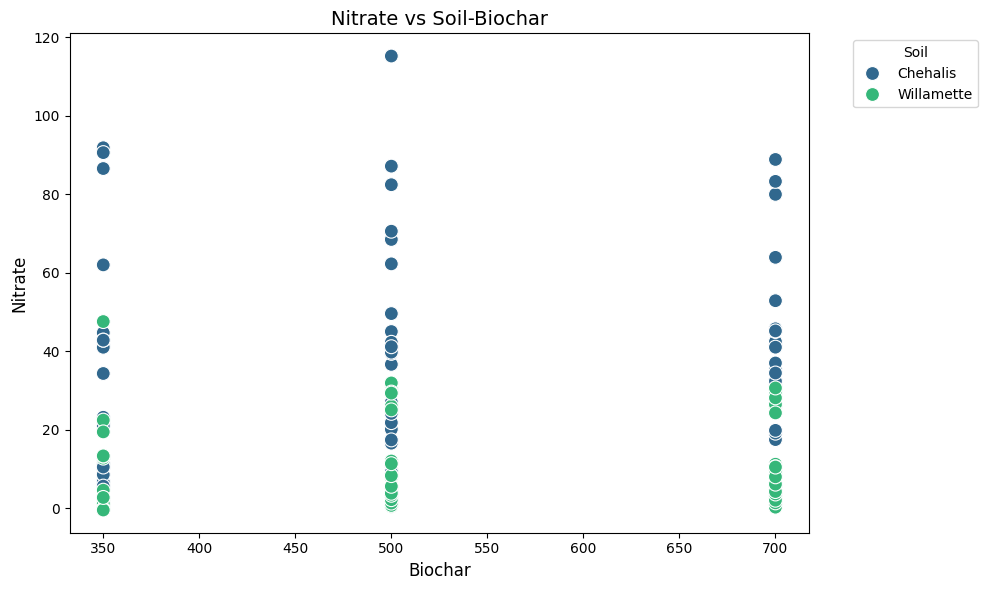

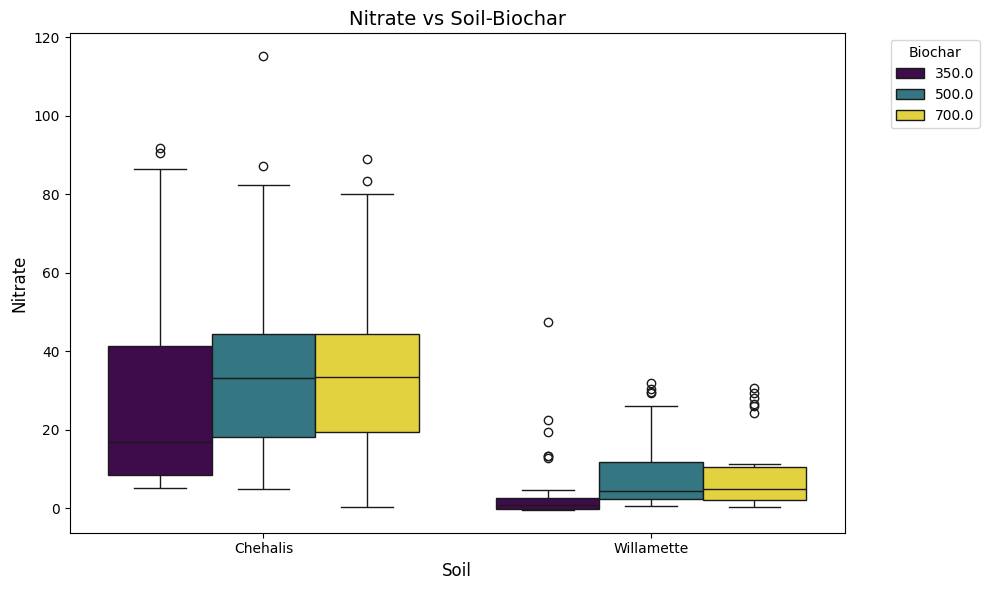

In [ ]:
# - - - Variable Plots - - - 

# Delta CO2 Plots
# No meaningful trend
create_scatter_plot(
    data=found_data, x_col='Soil', y_col='DeltaCO2',
    hue_col='Biochar',
    title='Delta CO2 vs Soil-Biochar')
create_box_plot(
    data=found_data, x_col='Soil', y_col='DeltaCO2',
    hue_col='Biochar', title='Delta CO2 vs Soil-Biochar')

# Fraction CO2 Plots
# Clear trend of increasing Biochar content decreasing Fraction CO2
create_scatter_plot(
    data=found_data, x_col='Soil', y_col='FractionCO2',
    hue_col='Biochar',
    title='Fraction CO2 vs Soil-Biochar')
create_box_plot(
    data=found_data, x_col='Soil', y_col='FractionCO2',
    hue_col='Biochar', title='Fraction CO2 vs Soil-Biochar')

# Grav Plots
# No meaningful relationship
create_scatter_plot(
    data=found_data, x_col='Soil', y_col='Grav',
    hue_col='Biochar',
    title='Grav vs Soil-Biochar')
create_box_plot(
    data=found_data, x_col='Soil', y_col='Grav',
    hue_col='Biochar', title='Grav vs Soil-Biochar')

# Nitrate Plots
# No meaningful relationship
create_scatter_plot(
    data=found_data, x_col='Biochar', y_col='Nitrate',
    hue_col='Soil',
    title='Nitrate vs Soil-Biochar')
create_box_plot(
    data=found_data, x_col='Soil', y_col='Nitrate',
    hue_col='Biochar', title='Nitrate vs Soil-Biochar')

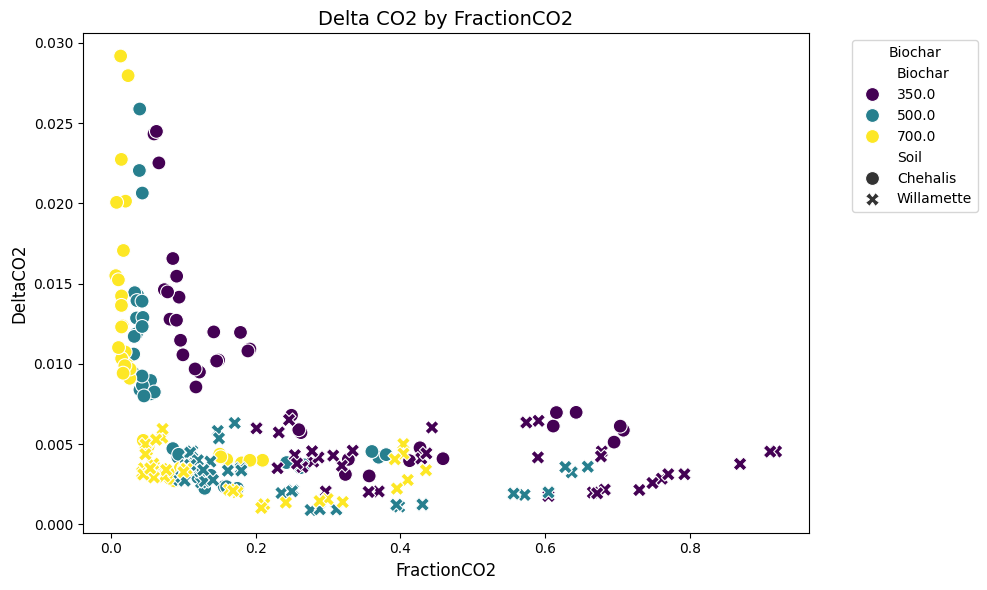

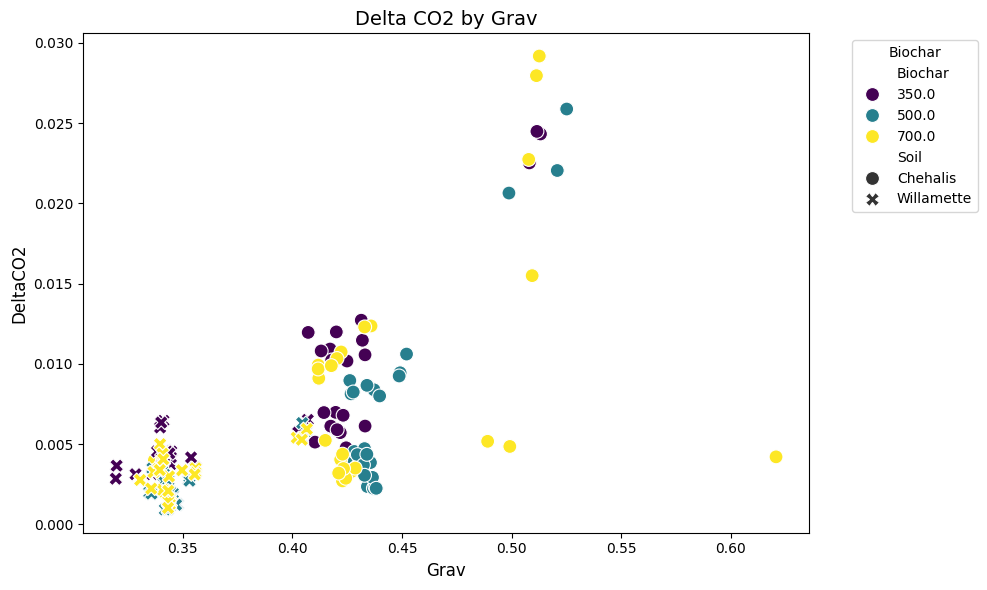

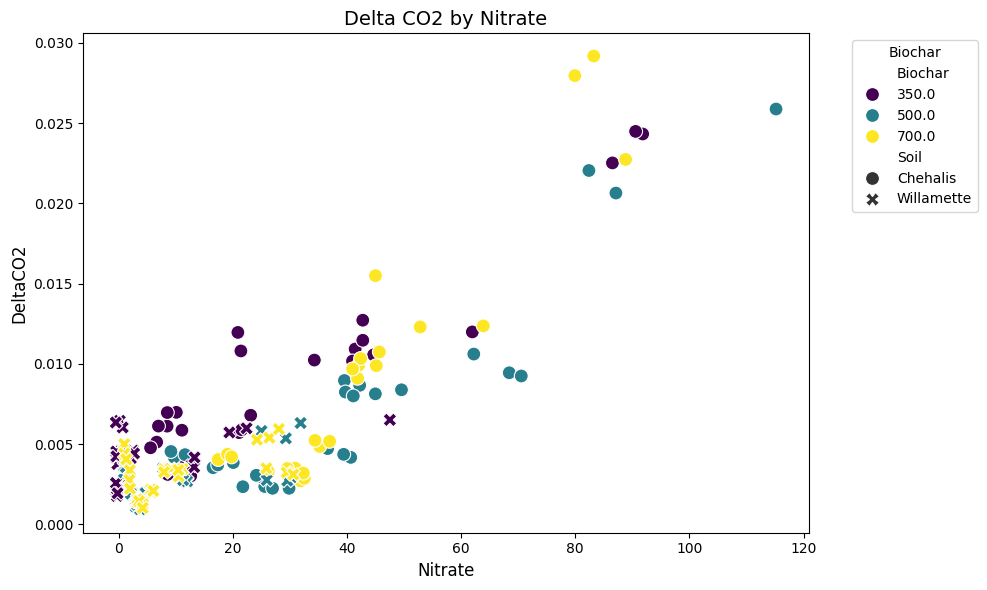

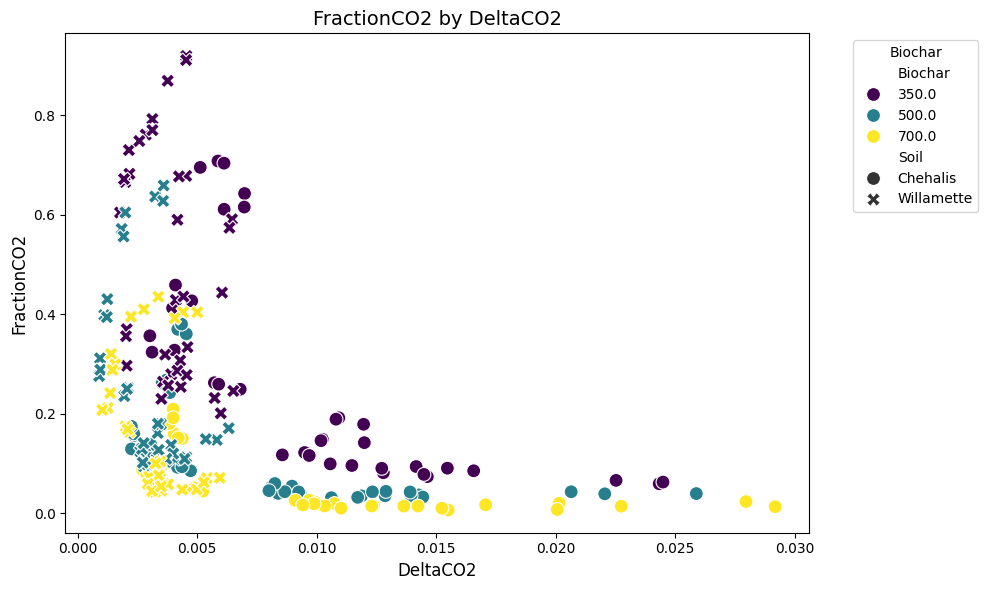

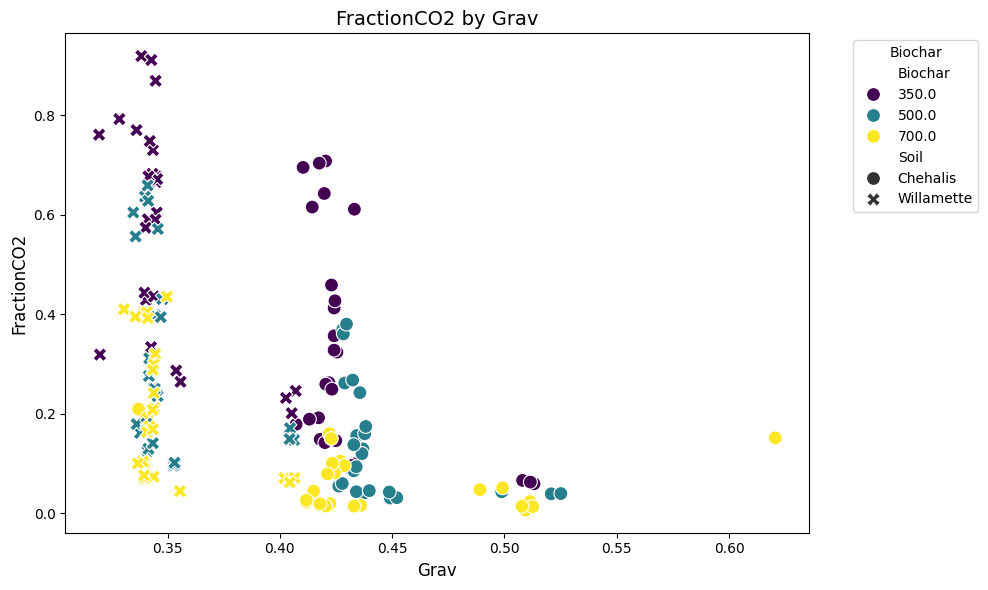

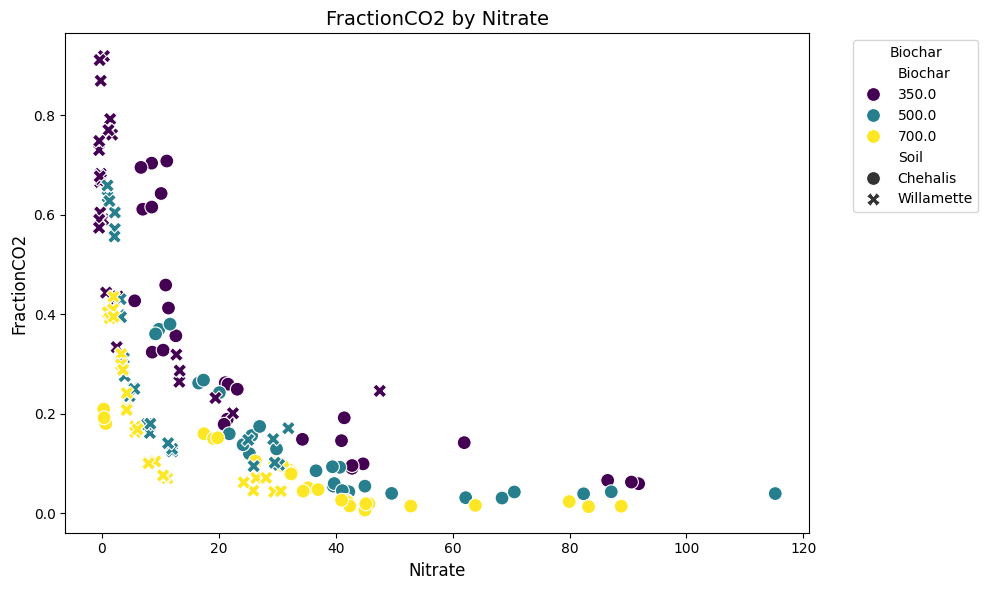

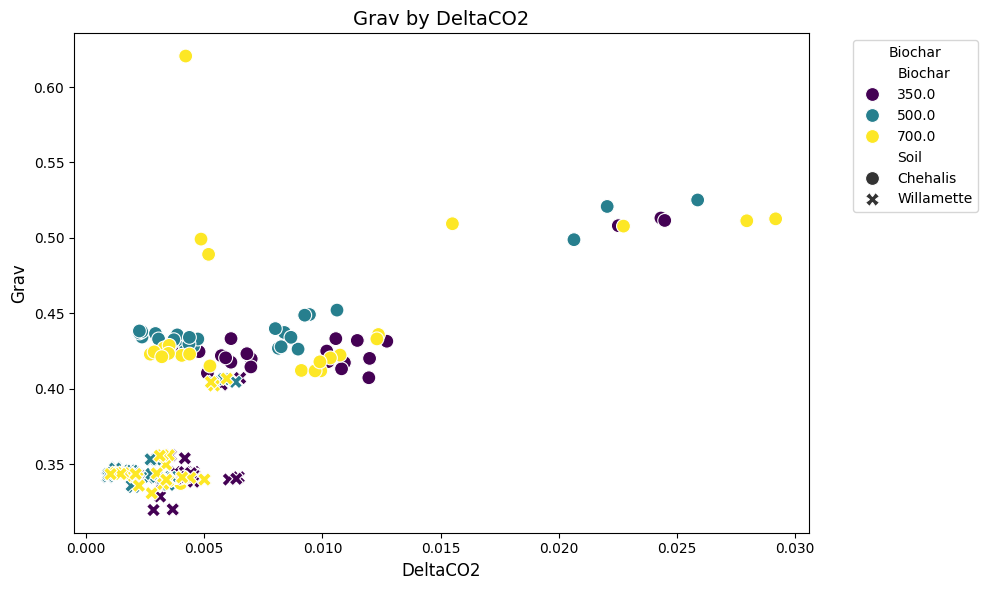

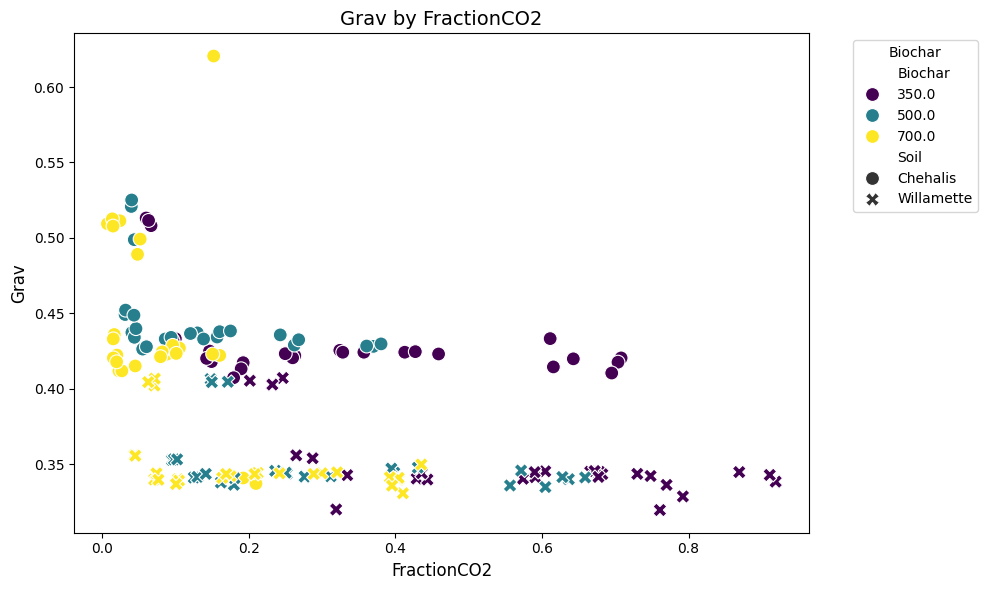

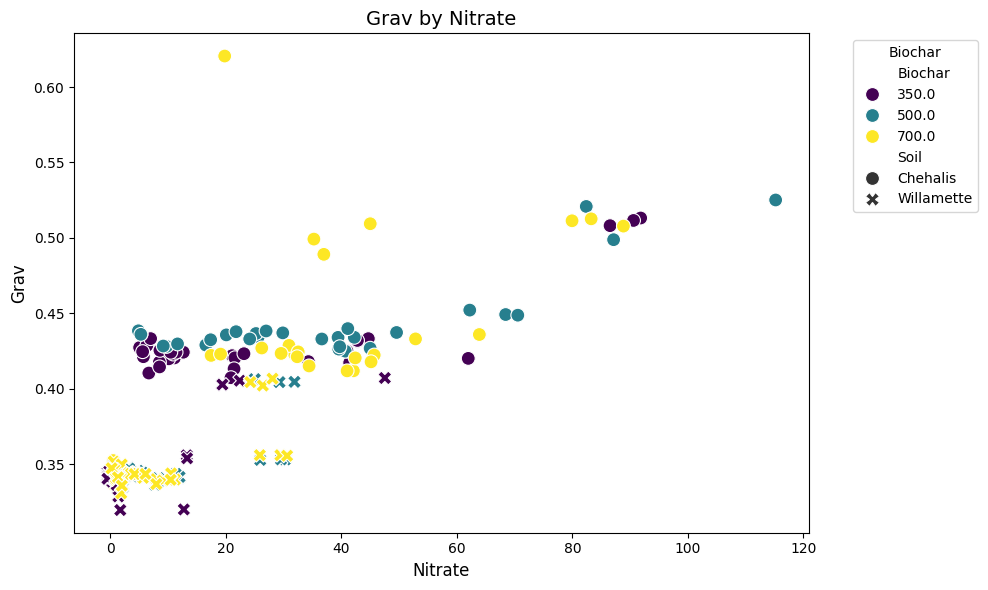

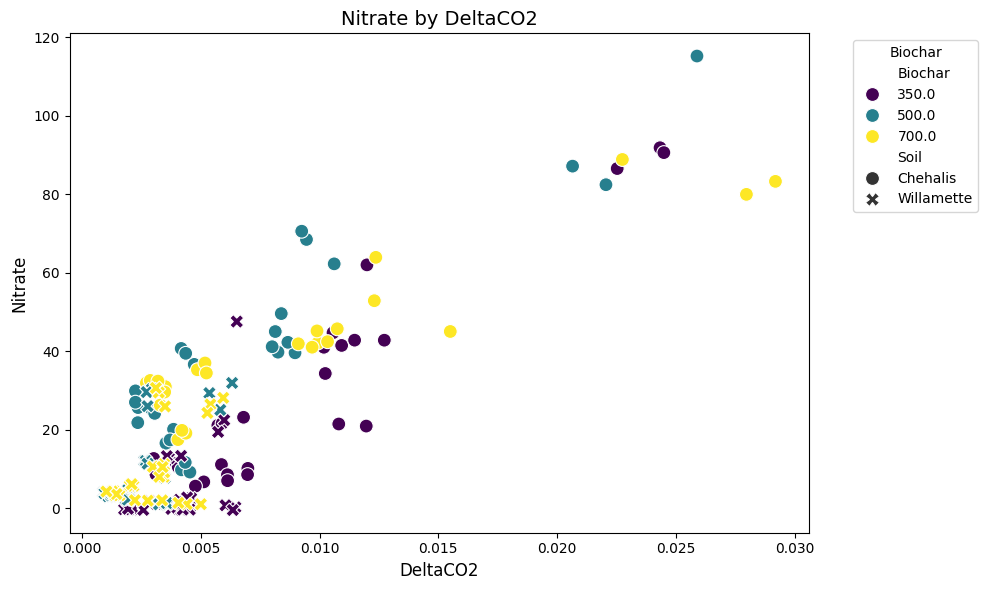

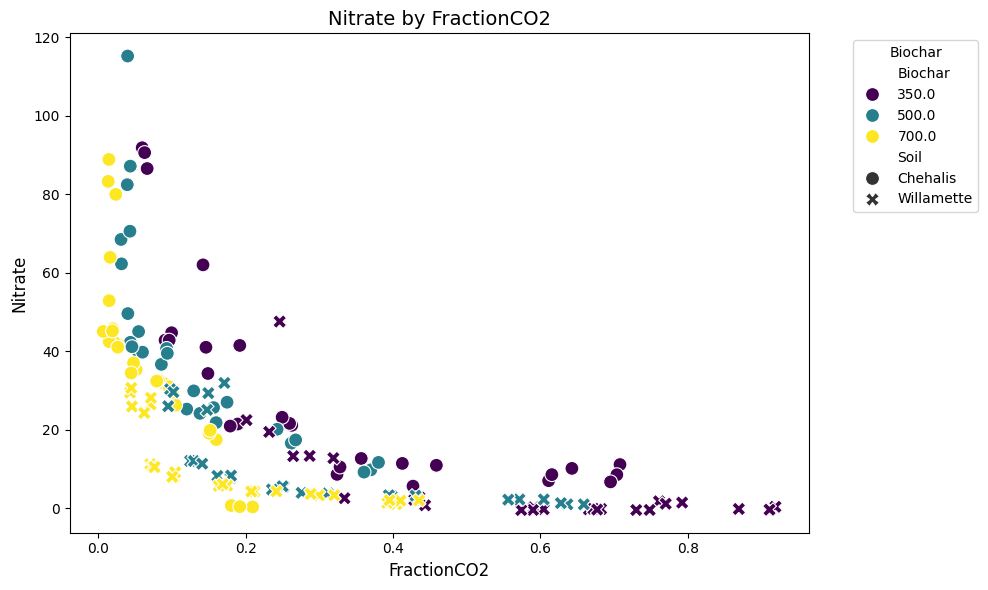

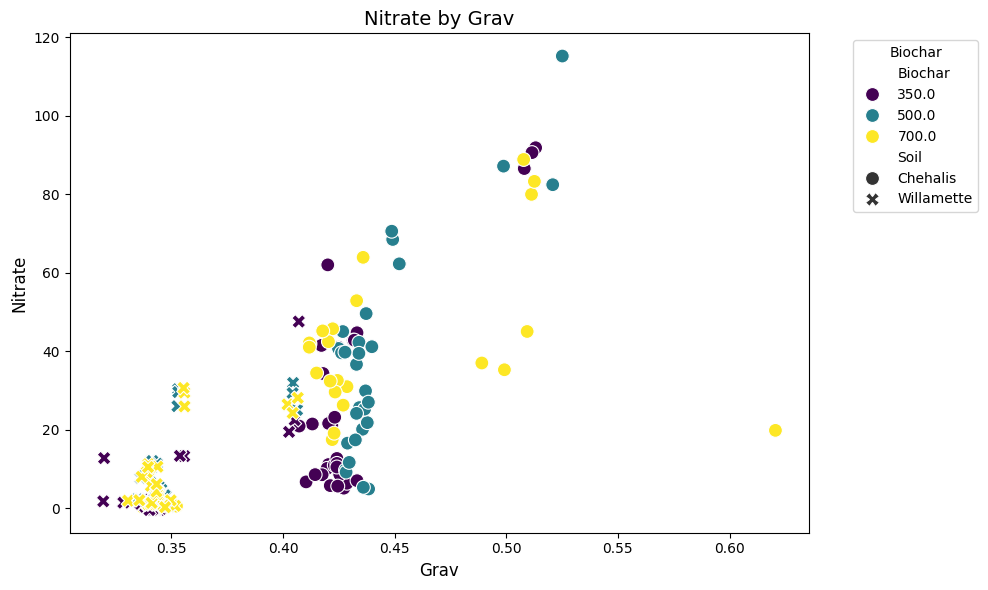

In [ ]:
# - - - More Complex Plots - - -

# - - - Delta CO2 - - - 

create_scatter_plot(
    data=found_data, x_col='FractionCO2', y_col='DeltaCO2',
    hue_col='Biochar', style_col='Soil',
    title='Delta CO2 by FractionCO2')

create_scatter_plot(
    data=found_data, x_col='Grav', y_col='DeltaCO2',
    hue_col='Biochar', style_col='Soil',
    title='Delta CO2 by Grav')

create_scatter_plot(
    data=found_data, x_col='Nitrate', y_col='DeltaCO2',
    hue_col='Biochar', style_col='Soil',
    title='Delta CO2 by Nitrate')

# - - - Fraction CO2 - - - 

create_scatter_plot(
    data=found_data, x_col='DeltaCO2', y_col='FractionCO2',
    hue_col='Biochar', style_col='Soil',
    title='FractionCO2 by DeltaCO2')

create_scatter_plot(
    data=found_data, x_col='Grav', y_col='FractionCO2',
    hue_col='Biochar', style_col='Soil',
    title='FractionCO2 by Grav')

create_scatter_plot(
    data=found_data, x_col='Nitrate', y_col='FractionCO2',
    hue_col='Biochar', style_col='Soil',
    title='FractionCO2 by Nitrate')

# - - - Grav - - - 

create_scatter_plot(
    data=found_data, x_col='DeltaCO2', y_col='Grav',
    hue_col='Biochar', style_col='Soil',
    title='Grav by DeltaCO2')

create_scatter_plot(
    data=found_data, x_col='FractionCO2', y_col='Grav',
    hue_col='Biochar', style_col='Soil',
    title='Grav by FractionCO2')

create_scatter_plot(
    data=found_data, x_col='Nitrate', y_col='Grav',
    hue_col='Biochar', style_col='Soil',
    title='Grav by Nitrate')

# - - - Nitrate - - -

create_scatter_plot(
    data=found_data, x_col='DeltaCO2', y_col='Nitrate',
    hue_col='Biochar', style_col='Soil',
    title='Nitrate by DeltaCO2')

create_scatter_plot(
    data=found_data, x_col='FractionCO2', y_col='Nitrate',
    hue_col='Biochar', style_col='Soil',
    title='Nitrate by FractionCO2')

create_scatter_plot(
    data=found_data, x_col='Grav', y_col='Nitrate',
    hue_col='Biochar', style_col='Soil',
    title='Nitrate by Grav')

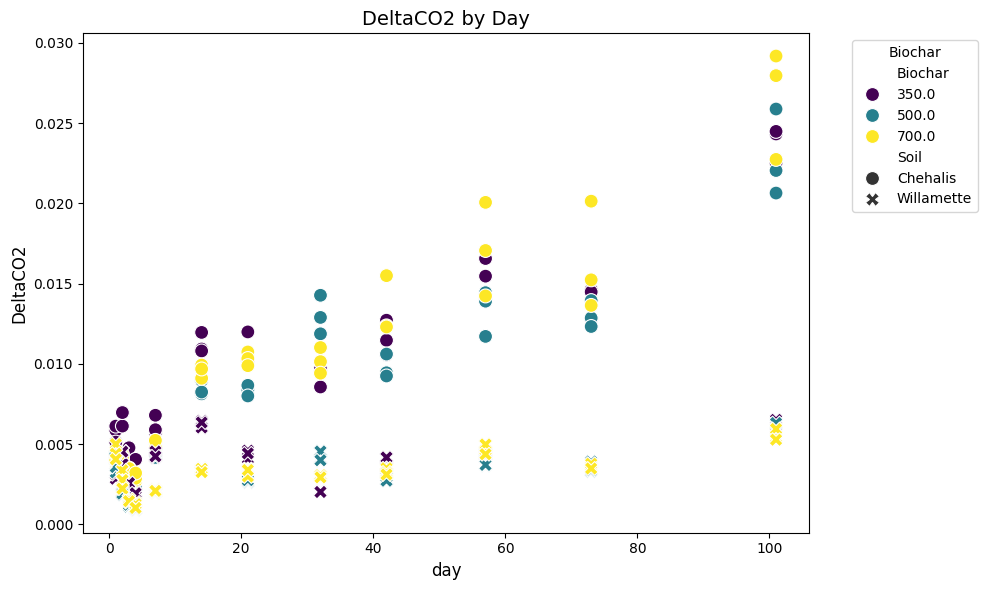

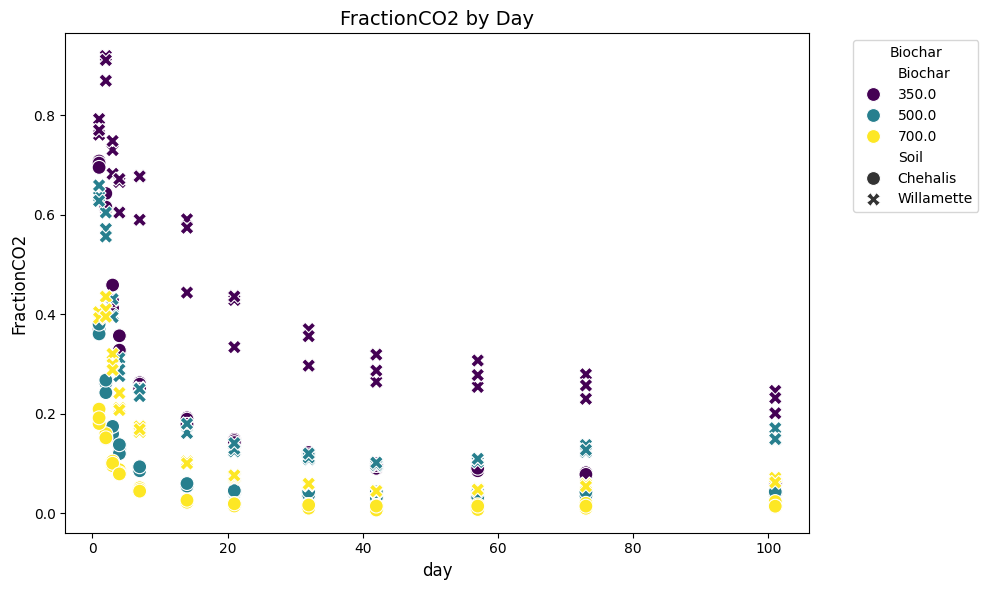

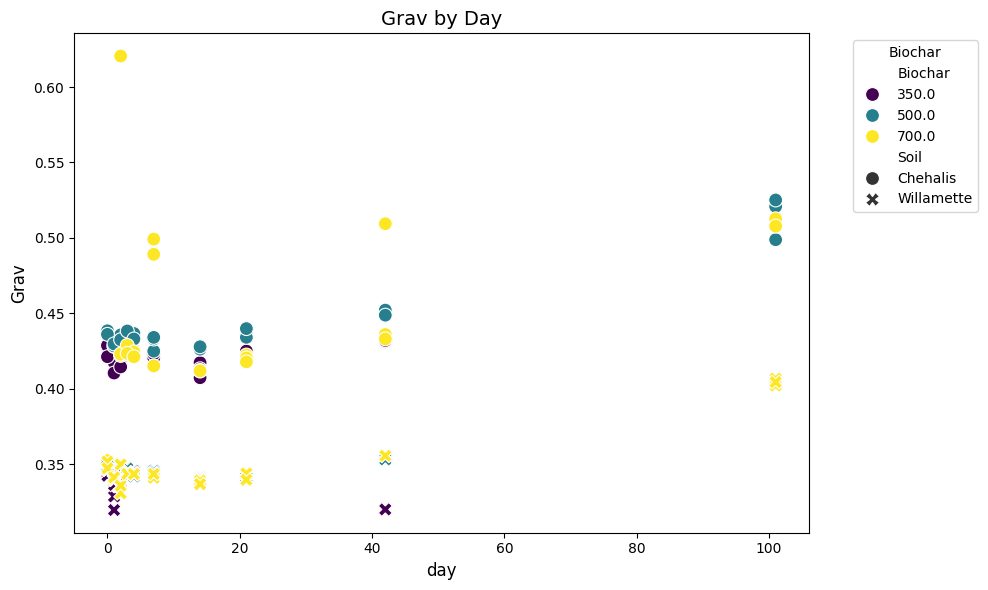

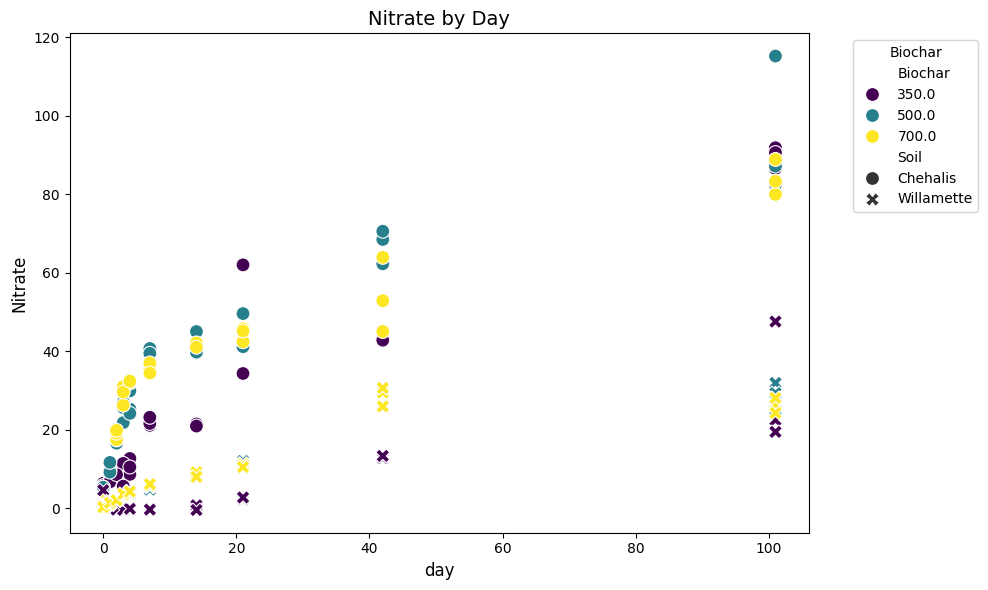

In [ ]:
# - - - Plots of Variables by Day - - - 
# FractionCO2 gets lower with days, other relationships seemingly irrelevant

create_scatter_plot(
    data=found_data, x_col='day', y_col='DeltaCO2',
    hue_col='Biochar', style_col='Soil',
    title='DeltaCO2 by Day')
    
create_scatter_plot(
    data=found_data, x_col='day', y_col='FractionCO2',
    hue_col='Biochar', style_col='Soil',
    title='FractionCO2 by Day')
    
create_scatter_plot(
    data=found_data, x_col='day', y_col='Grav',
    hue_col='Biochar', style_col='Soil',
    title='Grav by Day')
    
create_scatter_plot(
    data=found_data, x_col='day', y_col='Nitrate',
    hue_col='Biochar', style_col='Soil',
    title='Nitrate by Day')

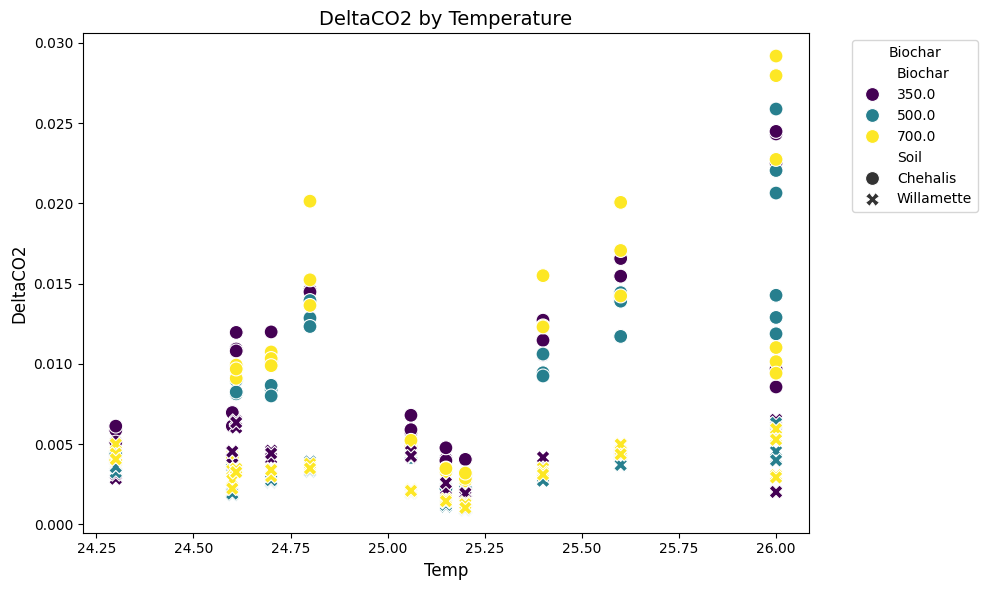

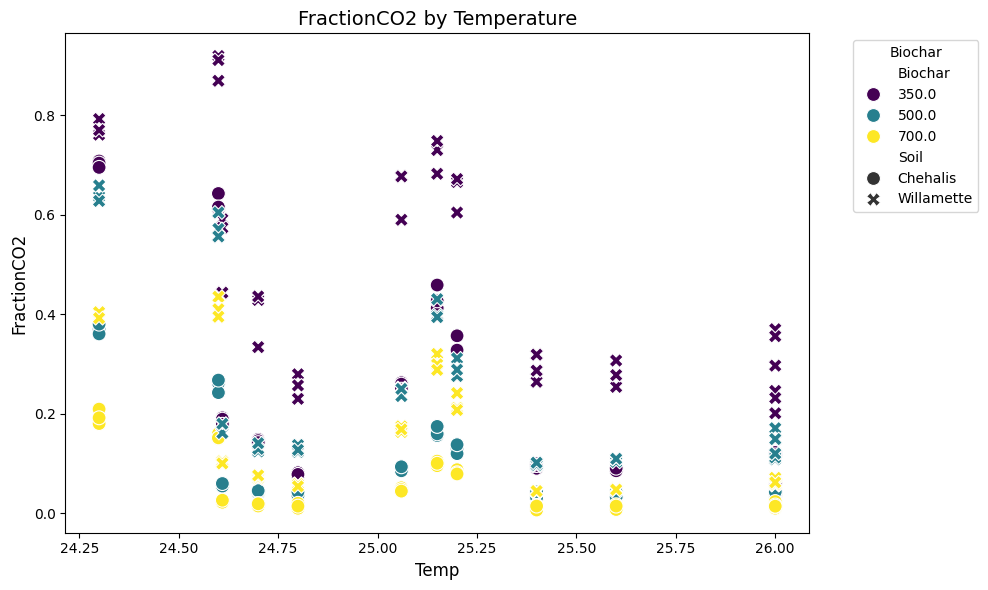

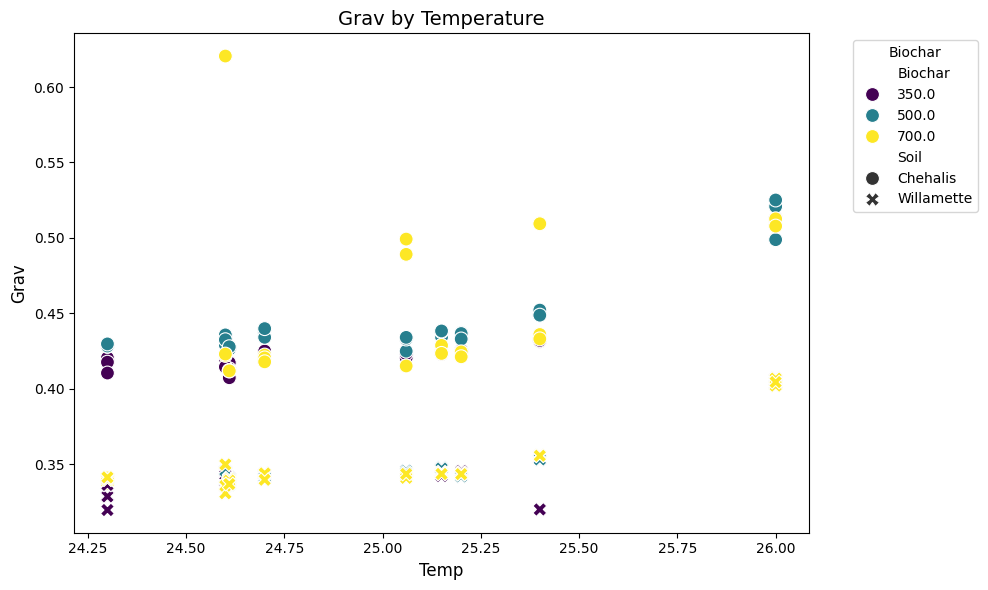

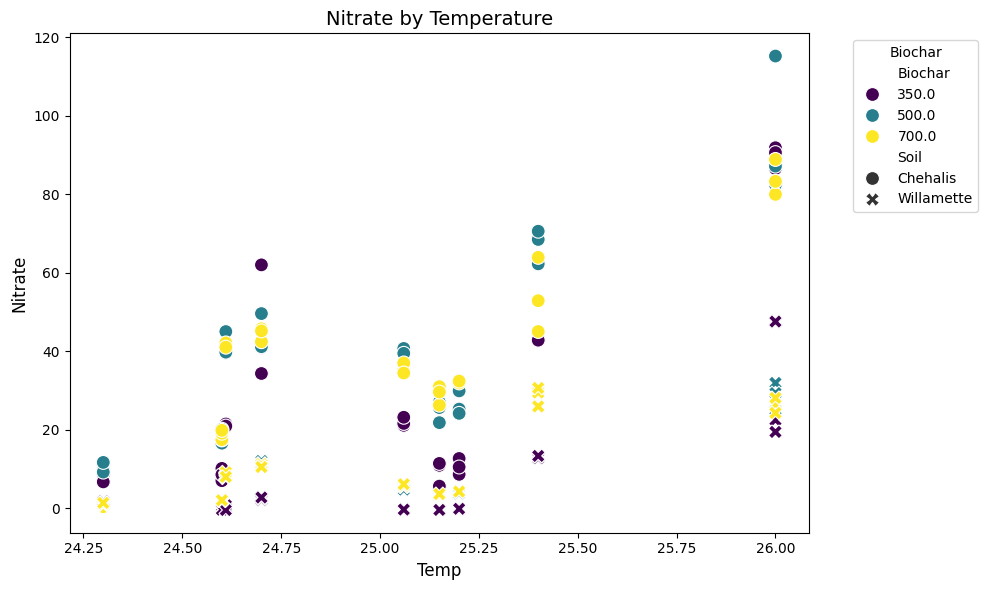

In [ ]:
# - - - Plots of Variables by Temperature - - - 
# Temp variable seems largely irrelevant

create_scatter_plot(
    data=found_data, x_col='Temp', y_col='DeltaCO2',
    hue_col='Biochar', style_col='Soil',
    title='DeltaCO2 by Temperature')
    
create_scatter_plot(
    data=found_data, x_col='Temp', y_col='FractionCO2',
    hue_col='Biochar', style_col='Soil',
    title='FractionCO2 by Temperature')
    
create_scatter_plot(
    data=found_data, x_col='Temp', y_col='Grav',
    hue_col='Biochar', style_col='Soil',
    title='Grav by Temperature')
    
create_scatter_plot(
    data=found_data, x_col='Temp', y_col='Nitrate',
    hue_col='Biochar', style_col='Soil',
    title='Nitrate by Temperature')